# Preparing an AF state in the Ising model

This purpose of this notebook is to illustrate how to build a sequence for preparing an AF state in the Ising model. This notebook is supposed to evolve with code updates. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from pulser import Pulse, Sequence, Register
from pulser.waveforms import ConstantWaveform, RampWaveform
from pulser.devices import AFM
from pulser.simulation import Simulation

simulation module...


## Initializing my device

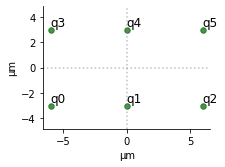

In [25]:
line_qubits = Register.rectangle(2,3, spacing=6, prefix='q')
line_qubits.draw()

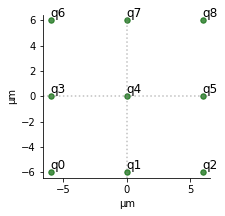

In [2]:
line_qubits = Register.square(side = 3, spacing=6, prefix='q')
line_qubits.draw()

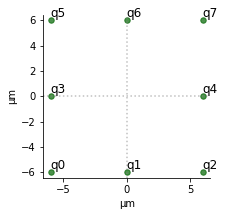

In [14]:
line_qubits = Register.square_1D(n_atoms = 8, spacing=6, prefix='q')
line_qubits.draw()

In [26]:
my_device = AFM(line_qubits) 
print(my_device.qubits)
print(my_device.name)

{'q0': array([-6., -3.]), 'q1': array([ 0., -3.]), 'q2': array([ 6., -3.]), 'q3': array([-6.,  3.]), 'q4': array([0., 3.]), 'q5': array([6., 3.])}
AFM


## Defining my waveforms 

We are realizing the following program

<img src="files/AF_Ising_program.png" alt="AF Pulse Sequence" style="width: 320px;"/>

In [27]:
# Parameters in MHz and ns
U = 1 * 2*np.pi  # btw 1-3 Mhz*2pi. Should we include this VdW magnitude in an AFM-type Simulation?

delta_0 = -2 * 2*np.pi
delta_f = 2 * 2*np.pi
Omega_max = 1. * 2*np.pi  # btw 1.8-2 Mhz*2pi
t_rise = 250
t_fall = 250
t_sweep = (delta_f-delta_0)/(2*np.pi*10) * 1000


In [28]:
rise = Pulse.ConstantDetuning(RampWaveform(t_rise, 0., Omega_max),
                              delta_0, 
                              0.)
sweep = Pulse.ConstantAmplitude(Omega_max,
                                RampWaveform(t_sweep, delta_0, delta_f),
                                0.)
fall = Pulse.ConstantDetuning(RampWaveform(t_fall, Omega_max, 0.),
                              delta_f,
                              0.)

## Creating my sequence

Channel: Ising_channel
t: 0 | Initial targets: q2, q1, q0, q3, q5, q4 | Phase Reference: 0.0 
t: 0->250 | Pulse(Amp=Ramp(0->6.28 MHz), Detuning=-12.6 MHz, Phase=0) | Targets: q2, q1, q0, q3, q5, q4
t: 250->650 | Pulse(Amp=6.28 MHz, Detuning=Ramp(-12.6->12.6 MHz), Phase=0) | Targets: q2, q1, q0, q3, q5, q4
t: 650->900 | Pulse(Amp=Ramp(6.28->0 MHz), Detuning=12.6 MHz, Phase=0) | Targets: q2, q1, q0, q3, q5, q4




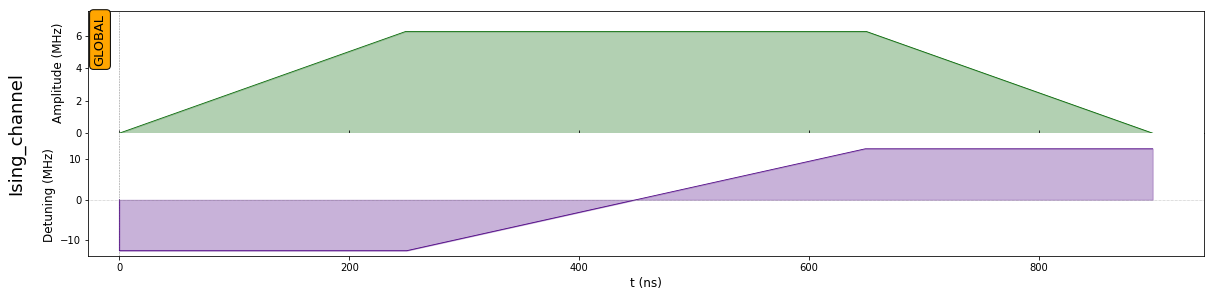

In [29]:
af_sequence = Sequence(my_device)
af_sequence.declare_channel('Ising_channel', 'rydberg_global')

af_sequence.add(rise, 'Ising_channel')
af_sequence.add(sweep, 'Ising_channel')
af_sequence.add(fall, 'Ising_channel')

print(af_sequence)
af_sequence.draw()

In [30]:
sweep.amplitude.integral

2.5132741228718345

# Simulation

In [31]:
simul = Simulation(af_sequence)

In [32]:
import qutip

up = qutip.basis(2,0)
down = qutip.basis(2,1)

all_down = qutip.tensor([down for _ in range(simul._size)])

In [33]:
def magnetization(j):
    prod = [qutip.qeye(2) for _ in range(simul._size)]
    prod[j] = qutip.sigmaz()
    return qutip.tensor(prod)

def occupation(j):
    prod = [qutip.qeye(2) for _ in range(simul._size)]
    prod[j] = up*up.dag()
    return qutip.tensor(prod)
    
magne_list = [magnetization(j) for j in range(simul._size)]
occup_list = [occupation(j) for j in range(simul._size//2)]

By parity symmetry, we only need to observe half of the atoms, the other one reflects the results

In [34]:
simul.run(obs_list=magne_list)

Observables provided. Calculating expectation value...


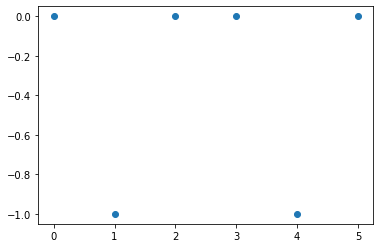

In [35]:
res = []
for x in simul.output:
    res.append(x[-1])
    
plt.plot(res,'o')

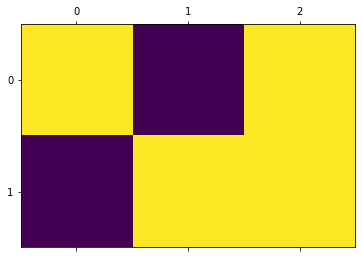

In [44]:
L = 3
res = np.zeros((2,3))
for i, m in enumerate(simul.output):
    res[i%2,i//3] = m[-1]
    
plt.matshow(res)